# Datathon #6 - Classification

This week, you will train a set of classifiers to label LEGO sets by theme, based on other metadata about the sets (year, number of parts, colors, or some combination of them). 

You should test at least 5 different classifiers:
+ kNN
+ Naïve Bayes
+ Decision Tree
+ Random Forest
+ Neural Network


For each classifier, report:
1. What parameters (if any) you tuned.
2. How well it performed. — Report the Accuracy, Precision, Recall, and F1-score. Also render a confusion matrix. (Remember, don’t test on your training data!)
3. Your interpretation of the result. Explain what you think the classifier got right/wrong. (Feel free to include visualizations or additional info that helps explain).

In [19]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import sklearn.metrics as skm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

We will use a variant of the second dataset from last week, adding a "theme" column.

** LEGO Colors by Set + Theme** — Contains data on the colors of the pieces in each LEGO set.

- Set Num = A unique alphanumeric ID number for each set. 
- Set Name = The official name of the set (some names are reused for more than one set).
- Year = The year the set was released.
- Num Parts = Total number of parts listed on the box.
- Theme = The theme the set was released under ("Technic", "Ninjago", "Star Wars", "City", etc.)
- [Colors] = Number of parts of each color in the set, according to the Rebrickable database.

You can also get more data about individual sets by going to http://rebrickable.com/sets/{SetNum}

In [20]:
# Import data, remove NaN
lego_frame_full = pd.read_excel('Set Color Data+Themes.xlsx')
lego_frame_full.fillna(0, inplace=True)

# For this datathon we'll just focus on 10 most popular themes.
lego_frame = lego_frame_full[(lego_frame_full["Theme"] == "Technic") | 
                        (lego_frame_full["Theme"] == "Friends") |
                        (lego_frame_full["Theme"] == "City") |
                        (lego_frame_full["Theme"] == "Basic Set") |
                        (lego_frame_full["Theme"] == "Creator") |
                        (lego_frame_full["Theme"] == "Duplo") |
                        (lego_frame_full["Theme"] == "Star Wars") |
                        (lego_frame_full["Theme"] == "Ninjago") |
                        (lego_frame_full["Theme"] == "Construction") |
                        (lego_frame_full["Theme"] == "Airport")]

In [21]:
lego_frame.head(3)

,Set Num,Set Name,Theme,Year,Num Parts,[No Color],Aqua,Black,Blue,Blue-Violet,...,Trans-Very Lt Blue,Trans-Yellow,Unknown,Very Light Bluish Gray,Very Light Gray,Very Light Orange,Violet,White,Yellow,Yellowish Green
4,2823692,Simple and Motorized Machines Activity Pack,Technic,1997,24,24.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2818944,Structures Set,Technic,1997,439,20.0,0.0,116.0,56.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2814926,Technology Activity Set,Technic,1994,318,17.0,0.0,92.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0


Some potentially useful refactorings of the data.

In [22]:
# Creates a copy of the dataframe where color counts are normalized 
#  so each gives the % of parts in the set with that color, rather than the total count.
norm_lego = lego_frame.copy()
norm_lego = norm_lego.drop([ 'Set Name', 'Set Num', 'Theme', 'Year', 'Num Parts'], axis=1)
norm_lego = norm_lego.div(norm_lego.sum(axis=1), axis=0)

# A list of all the color name columns
color_cols = norm_lego.columns
# A list of all the other numeric columns
other_cols = ["Year", "Num Parts"]

# Add back the non-numeric columns to the normalized table
norm_lego["Year"] = lego_frame["Year"]
norm_lego["Set Name"] = lego_frame["Set Name"]
norm_lego["Set Num"] = lego_frame["Set Num"]
norm_lego["Theme"] = lego_frame["Theme"]
norm_lego["Num Parts"] = lego_frame["Num Parts"]
norm_lego.head(3)

,[No Color],Aqua,Black,Blue,Blue-Violet,Bright Green,Bright Light Blue,Bright Light Orange,Bright Light Yellow,Bright Pink,...,Very Light Orange,Violet,White,Yellow,Yellowish Green,Year,Set Name,Set Num,Theme,Num Parts
4,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1997,Simple and Motorized Machines Activity Pack,2823692,Technic,24
8,0.045558,0.0,0.264237,0.127563,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1997,Structures Set,2818944,Technic,439
10,0.051360,0.0,0.277946,0.006042,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.006042,0.003021,0.0,1994,Technology Activity Set,2814926,Technic,318


In [6]:
color_cols # The complete list of color columns

Index(['[No Color]', 'Aqua', 'Black', 'Blue', 'Blue-Violet', 'Bright Green',
       'Bright Light Blue', 'Bright Light Orange', 'Bright Light Yellow',
       'Bright Pink',
       ...
       'Trans-Very Lt Blue', 'Trans-Yellow', 'Unknown',
       'Very Light Bluish Gray', 'Very Light Gray', 'Very Light Orange',
       'Violet', 'White', 'Yellow', 'Yellowish Green'],
      dtype='object', length=131)

## Training and Test Splits
Make sure you don't accidentally test on your training data.

In [64]:
# Generate test and training sets
from sklearn.model_selection import train_test_split

ynp_train, ynp_test, theme_train, theme_test = sk.model_selection.train_test_split(
    lego_frame[color_cols],lego_frame['Theme'], test_size=0.4)

## k-Nearest Neighbors

In [65]:
from sklearn.neighbors import KNeighborsClassifier

# Be sure to look at the available parameters on each classifier.
# For example, you might want to experiment with the number of neighbours here. 
n=4   
lego_knn = KNeighborsClassifier(n_neighbors=n)
lego_knn.fit(ynp_train, theme_train) #TODO — substitute in your own training data

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [66]:
lego_knn_predictions = lego_knn.predict(ynp_test) #TODO — substitute in your own test data
lego_knn_predictions

array(['Construction', 'Ninjago', 'Star Wars', 'Airport', 'Airport',
       'Friends', 'City', 'City', 'Airport', 'Ninjago', 'Creator',
       'Technic', 'Airport', 'Basic Set', 'City', 'Construction',
       'Creator', 'Creator', 'City', 'Technic', 'Technic', 'Friends',
       'Technic', 'Duplo', 'Star Wars', 'Friends', 'Technic', 'Technic',
       'Star Wars', 'Ninjago', 'Technic', 'Airport', 'City', 'Technic',
       'Star Wars', 'Technic', 'Construction', 'City', 'Airport',
       'Technic', 'Technic', 'Technic', 'Friends', 'Star Wars', 'Technic',
       'City', 'Airport', 'Friends', 'City', 'Basic Set', 'City',
       'Star Wars', 'City', 'Duplo', 'Construction', 'Airport',
       'Star Wars', 'Technic', 'Construction', 'Technic', 'Basic Set',
       'Duplo', 'Construction', 'Technic', 'Technic', 'Construction',
       'Friends', 'Duplo', 'Technic', 'Construction', 'Star Wars', 'City',
       'Construction', 'City', 'Technic', 'Airport', 'Construction',
       'Construction', 'Nin

## Naive Bayes

In [67]:
from sklearn.naive_bayes import GaussianNB

In [68]:
def plot_class(df, classifier, npts=500): #500x500 points will look smooth but take a few seconds
    xx,yy=np.meshgrid(np.linspace(df['Year'].min()-10,df['Num Parts'].max()+10,num=npts), 
                      np.linspace(df['Year'].min()-4,df['Num Parts'].max()+4,num=npts))
    Zstring = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    repdict = {"Technic":1, "Friends":2,"City":3, "Basic Set":4, "Creator":5,
                      "Duplo":6, "Star Wars":7, "Ninjago":8,"Construction":9, "Airport":10}
    Z = np.zeros_like(Zstring)
    for k,v in repdict.items():
        Z[Zstring==k]=v
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.get_cmap('RdBu',6),vmin=0,vmax=5)
    plt.xlabel('Year');plt.ylabel('Num Parts')
    cbar = plt.colorbar(ticks=[1,2,3,4,5])
    cbar.ax.set_yticklabels(["Technic", "Friends","City", "Basic Set", "Creator",
                      "Duplo", "Star Wars", "Ninjago","Construction", "Airport"])
    plt.scatter(df['Year'],df['Num Parts'], color="black",alpha=0.2)

In [69]:

lego_gnb = GaussianNB().fit(ynp_train, theme_train)
lego_gnb_predictions = lego_gnb.predict(ynp_test)
#plot_class(lego_frame,lego_gnb)

In [70]:
#Accuracy
skm.accuracy_score(y_true=theme_test,
                   y_pred=lego_gnb_predictions)

0.43305439330543932

In [71]:
# Precision
skm.precision_score(y_true=theme_test,
                    y_pred=lego_gnb_predictions,
                    average='weighted')

0.46767095405079628

In [72]:
# Recall
skm.recall_score(y_true=theme_test,
                 y_pred=lego_gnb_predictions,
                 average='weighted')

0.43305439330543932

In [73]:
# F1 Score
skm.f1_score(y_true=theme_test,
                 y_pred=lego_gnb_predictions,
             average='weighted')

0.40253250673482138

In [74]:
# Compute the confusion matrix
nba_neigh_cfmat = skm.confusion_matrix(
    y_true=theme_test,
                 y_pred=lego_gnb_predictions,)
nba_neigh_cfmat

array([[ 33,   0,   5,   1,   1,   0,   0,   0,   2,  22],
       [ 24,  10,   1,   6,  13,   7,   4,   1,   0,  30],
       [  5,   1,  24,   3,   1,   0,   0,   1,   2,  74],
       [  9,   0,   6,   7,   2,   0,   0,   0,   0,  52],
       [ 21,   1,  20,   2,  13,   0,   5,   4,   3,  26],
       [  1,   4,  10,   2,   5,  52,   3,   0,   1,  11],
       [  0,   1,   9,   3,   0,  17,  71,   0,   1,   4],
       [  0,   0,  18,   1,   2,   7,   1,  41,   5,   2],
       [  5,   1,  24,   1,   1,   5,   1,   1,  18,  25],
       [  1,   3,   2,   5,   2,   0,   0,   1,   1, 145]], dtype=int64)

Text(0.5,1,'Confusion Matrix')

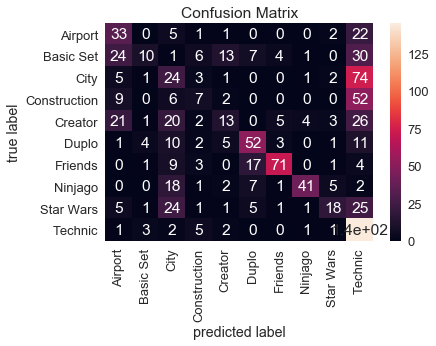

In [76]:
# Visualize the confusion matrix
sns.heatmap(nba_neigh_cfmat, 
            xticklabels=lego_gnb.classes_,
            yticklabels=lego_gnb.classes_,
            annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix')


## Decision Trees

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
#TODO — Train and test

#### Drawing a Decision Tree
Rendering decision trees requires the graphviz package. You can install it from the terminal or command line using:
> conda install python-graphviz

In [14]:
import graphviz 
graph_data = sk.tree.export_graphviz(YOUR_CLASSIFIER, out_file=None,
                         feature_names=YOUR_FEATURE_NAMES,  
                         class_names=YOUR_CLASS_NAMES,  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(graph_data) 
graph

# Or save out to a file using this command:
# graph.render("decision_tree") 

NameError: name 'YOUR_CLASSIFIER' is not defined

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#TODO — Train and test

## Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
#TODO — Train and test